# 규제가 있는 선형회귀 - 릿지, 라쏘, 엘라스틱넷 회귀

#### 규제가 있는 모델 구축 - 당뇨병 데이터세트
#### 1. 데이터 전처리---> scailing
#### 2. Ridge, Lasso, Elasticnet regression 구축: 회귀 계수 확인, 하이퍼 파라미터 탐색( 규제에 가까운 알파값 )
#### 3. 교차 검증으로 최적의 하이퍼파라미터 탐색: LassoCV() 

In [190]:
# 관련 라이브러리 및 모듈 Import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [191]:
# warning mse 띄우지 마
import warnings
warnings.filterwarnings(action = 'ignore')

# 0. 데이터 수집, 탐색, 준비

In [192]:
from sklearn.datasets import load_diabetes

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [193]:
def evaluate_score(y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    print(f'mse - {mse:.3f}')
    print(f'rmse - {rmse:.3f}')
    print(f'r2 - {r2:.3f}')
    
    return

####  데이터셋에 대한 설명 및 정보 확인

In [194]:
# 데이터셋 정보확인

In [195]:
diab = load_diabetes()
diab

{'data': array([[ 0.03807591,  0.05068012,  0.06169621, ..., -0.00259226,
          0.01990749, -0.01764613],
        [-0.00188202, -0.04464164, -0.05147406, ..., -0.03949338,
         -0.06833155, -0.09220405],
        [ 0.08529891,  0.05068012,  0.04445121, ..., -0.00259226,
          0.00286131, -0.02593034],
        ...,
        [ 0.04170844,  0.05068012, -0.01590626, ..., -0.01107952,
         -0.04688253,  0.01549073],
        [-0.04547248, -0.04464164,  0.03906215, ...,  0.02655962,
          0.04452873, -0.02593034],
        [-0.04547248, -0.04464164, -0.0730303 , ..., -0.03949338,
         -0.00422151,  0.00306441]]),
 'target': array([151.,  75., 141., 206., 135.,  97., 138.,  63., 110., 310., 101.,
         69., 179., 185., 118., 171., 166., 144.,  97., 168.,  68.,  49.,
         68., 245., 184., 202., 137.,  85., 131., 283., 129.,  59., 341.,
         87.,  65., 102., 265., 276., 252.,  90., 100.,  55.,  61.,  92.,
        259.,  53., 190., 142.,  75., 142., 155., 225.,  59

In [196]:
diab.feature_names

['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']

#### 데이터프레임 변환

In [197]:
# 독립변수(피처)와 종속변수를 DataFrame자료형으로 변환

In [198]:
# 데이터셋 객체의 data 배열, 즉, 독립변수 X가되는 피처(특성)들을 DataFrame자료형으로 변환하여
# diab_df생성
# diab_df.head() 데이터 5개 확인

diab_df = pd.DataFrame(data = diab.data, columns = diab.feature_names)
diab_df.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641


In [199]:
# 누락치 확인,  data type 확인 ->  isnull().sum(), target에 결측값이 있으면 해당 관측치 제거

In [200]:
# 결측치 없는지 확인
diab_df.isnull().sum() # null이 있으면 T 없으면 F / sum을 해보아라 결측치가 있는지

age    0
sex    0
bmi    0
bp     0
s1     0
s2     0
s3     0
s4     0
s5     0
s6     0
dtype: int64

In [201]:
diab_df.info() # 로도 찾아볼수 있음

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     442 non-null    float64
 1   sex     442 non-null    float64
 2   bmi     442 non-null    float64
 3   bp      442 non-null    float64
 4   s1      442 non-null    float64
 5   s2      442 non-null    float64
 6   s3      442 non-null    float64
 7   s4      442 non-null    float64
 8   s5      442 non-null    float64
 9   s6      442 non-null    float64
dtypes: float64(10)
memory usage: 34.7 KB


In [202]:
# X(독립변수), Y(종속변수) 분할
x = diab.data
y = diab.target

In [203]:
# 학습용, 평가용 데이터 분리
# test_size = 0.3, random_state = 42
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.3, random_state = 42)

# 모델별 계수변화, 알파별 계수 비교 데이터프레임(comp_df)

In [204]:
#각 모델별 계수로 이루어진 데이터프레임 준비
# ['R2 scores'] 추가
comp_df = pd.DataFrame(index = diab.feature_names + ['R2 scores'])
comp_df

""
age
sex
bmi
bp
s1
s2
s3
s4
s5
s6


In [205]:
#각 모델별, 규제강도별 평가지표 저장


# 1. 규제가 없는 선형모델

In [206]:
#모델 구축 및 학습
model_lr = LinearRegression()

model_lr.fit(x_train, y_train)

#모델 평가
y_pred = model_lr.predict(x_test)
r2 = r2_score(y_test, y_pred)
print('r2: ', r2 )

# 회귀 계수 확인
lr_coef = pd.Series(model_lr.coef_, index = diab.feature_names)
print(lr_coef)

r2:  0.4772897164322617
age     29.254013
sex   -261.706469
bmi    546.299723
bp     388.398341
s1    -901.959668
s2     506.763241
s3     121.154351
s4     288.035267
s5     659.268951
s6      41.376701
dtype: float64


- 계수값 시각화

In [207]:
coef = lr_coef.sort_values(ascending = False)
# print(coef)
coef = np.abs(lr_coef).sort_values(ascending = False)
# print('=====')
# print(coef)

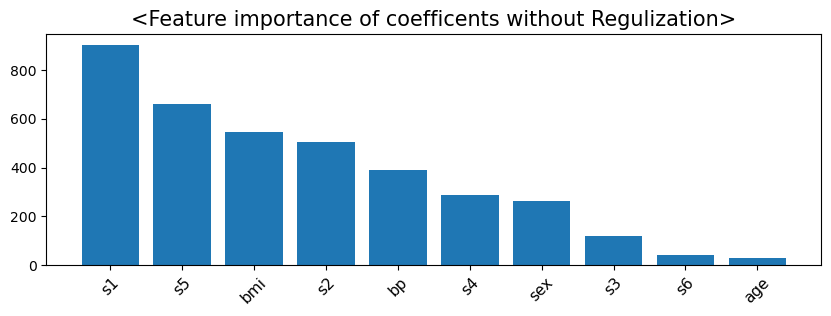

In [208]:
# 시각화
plt.figure(figsize = (10,3))
plt.title('<Feature importance of coefficents without Regulization>',
         fontsize = 15)
plt.bar(coef.index, coef.values);
plt.xticks(coef.index, rotation = 45, fontsize = 11);

In [209]:
# 모델별 비교 데이터프레임 열 추가
# 방금 한 시각화 DataFrame에 추가

comp_df['LR'] = np.append(model_lr.coef_, r2)
comp_df

,LR
age,29.254013
sex,-261.706469
bmi,546.299723
bp,388.398341
s1,-901.959668
s2,506.763241
s3,121.154351
s4,288.035267
s5,659.268951
s6,41.376701


# 1. 릿지 모델

In [210]:
from sklearn.linear_model import Ridge
# 객체 생성 모델 릿지
model_ridge = Ridge(alpha = 1)
model_ridge.fit(x_train,y_train) # alpha = 1

Ridge(alpha=1)

In [211]:
# 릿지 선형회귀 모델 평가: model_Ridge1, alpha=1
y_pred = model_ridge.predict(x_test)
r2 = r2_score(y_test, y_pred)
# a=1일때 회귀 계수 확인
ridge_coef = pd.Series(model_ridge.coef_, index = diab.feature_names)
ridge_coef

age     45.054210
sex    -71.947397
bmi    280.716252
bp     195.212662
s1      -2.229303
s2     -17.540797
s3    -148.688862
s4     120.467240
s5     198.614401
s6     106.934692
dtype: float64

In [212]:
# 선형 모델 평가


#a = 1 릿지 모델 회귀 계수


- 계수값 시각화

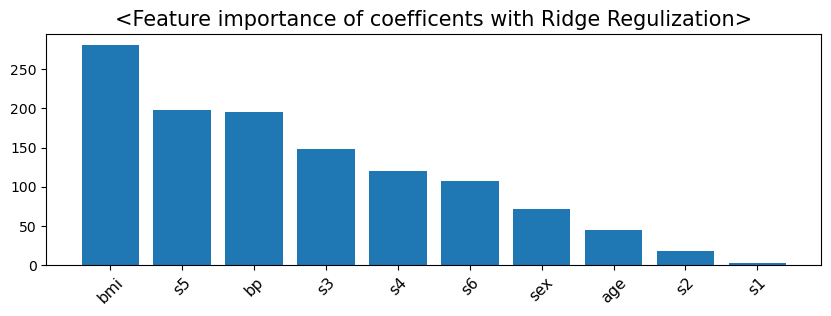

In [213]:
# 릿지의 절대값을 만들어서 시리즈로
coef = pd.Series(np.abs(model_ridge.coef_), index = diab.feature_names).sort_values(ascending = False)
coef
# 시각화
plt.figure(figsize = (10, 3))
plt.title('<Feature importance of coefficents with Ridge Regulization>',
         fontsize = 15)
plt.bar(coef.index, coef.values)
plt.xticks(coef.index, rotation = 45, fontsize = 11) ;

In [214]:
# alpha_list=[0.01, 1, 10, 100]인 경우

alpha_list = [0.01, 1, 10, 100]

for each in alpha_list:
    model_ridge = Ridge(alpha = each)
    model_ridge.fit(x_train,y_train)
    
    y_pred = model_ridge.predict(x_test)
    r2 = r2_score(y_test, y_pred)
    col_name = f'ridge(alpha = {each:.2f}'
    comp_df[col_name]= np.append(model_ridge.coef_, r2)

In [215]:
comp_df

,LR,ridge(alpha = 0.01,ridge(alpha = 1.00,ridge(alpha = 10.00,ridge(alpha = 100.00
age,29.254013,34.167328,45.054210,16.230889,2.072848
sex,-261.706469,-254.043316,-71.947397,-2.961367,-0.003808
bmi,546.299723,550.844882,280.716252,59.524160,6.899915
bp,388.398341,379.126708,195.212662,43.421300,5.085100
s1,-901.959668,-404.253263,-2.229303,13.875073,2.069660
s2,506.763241,123.029219,-17.540797,10.865267,1.743748
s3,121.154351,-99.041674,-148.688862,-37.495847,-4.508876
s4,288.035267,215.032624,120.467240,38.728538,4.902421
s5,659.268951,463.842634,198.614401,49.224746,5.926496
s6,41.376701,50.351490,106.934692,34.737987,4.328698


# 2. 라쏘 모델

In [216]:
from sklearn.linear_model import Lasso

# alpha = 1
model_lasso = Lasso(alpha = 1)
model_lasso.fit(x_train, y_train)

Lasso(alpha=1)

In [217]:
# 라쏘 선형회귀 모델 평가(alpha=1)
# 선형 모델 평가
y_pred = model_lasso.predict(x_test)
r2 + r2_score(y_test,y_pred)
print(r2)
#a = 1 라쏘 모델 회귀 계수

lasso_coef = pd.Series(model_lasso.coef_, index = diab.feature_names)
lasso_coef

0.014769501009581631


age      0.000000
sex     -0.000000
bmi    443.703388
bp      51.601094
s1       0.000000
s2       0.000000
s3      -0.000000
s4       0.000000
s5     201.966478
s6       0.000000
dtype: float64

- 계수 시각화

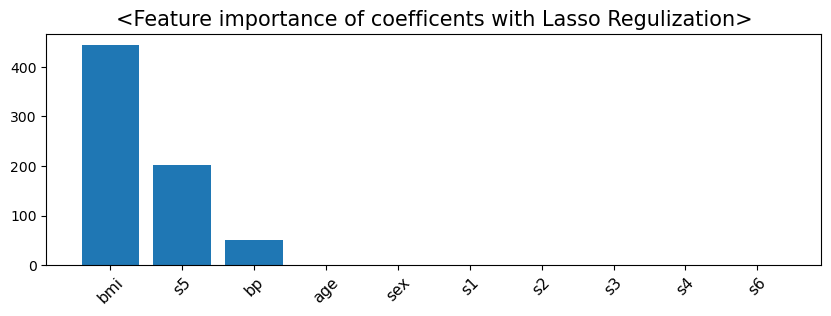

In [218]:
coef = np.abs(lasso_coef)    # 규제된 회귀계수의 절대값을 계산
coef = pd.Series(coef, index = diab.feature_names).sort_values(ascending = False)
coef
# 시각화
plt.figure(figsize = (10, 3))
plt.title('<Feature importance of coefficents with Lasso Regulization>',
         fontsize = 15)
plt.bar(coef.index, coef.values)
plt.xticks(coef.index, rotation = 45, fontsize = 11) ;

In [219]:
# alpha_list=[0.01, 1, 10, 100]인 경우

alpha_list = [0.01, 1, 10, 100]

for each in alpha_list:
    model_lasso = Lasso(alpha = each)
    model_lasso.fit(x_train,y_train)
    
    y_pred = model_lasso.predict(x_test)
    r2 = r2_score(y_test, y_pred)
    col_name = f'lasso(alpha = {each:.2f}'
    comp_df[col_name]= np.append(model_lasso.coef_, r2)

In [220]:
comp_df

,LR,ridge(alpha = 0.01,ridge(alpha = 1.00,ridge(alpha = 10.00,ridge(alpha = 100.00,lasso(alpha = 0.01,lasso(alpha = 1.00,lasso(alpha = 10.00,lasso(alpha = 100.00
age,29.254013,34.167328,45.054210,16.230889,2.072848,28.246364,0.000000,0.000000,0.000000
sex,-261.706469,-254.043316,-71.947397,-2.961367,-0.003808,-250.819184,-0.000000,0.000000,0.000000
bmi,546.299723,550.844882,280.716252,59.524160,6.899915,556.215874,443.703388,0.000000,0.000000
bp,388.398341,379.126708,195.212662,43.421300,5.085100,380.659502,51.601094,0.000000,0.000000
s1,-901.959668,-404.253263,-2.229303,13.875073,2.069660,-468.739540,0.000000,0.000000,0.000000
s2,506.763241,123.029219,-17.540797,10.865267,1.743748,166.993417,0.000000,0.000000,0.000000
s3,121.154351,-99.041674,-148.688862,-37.495847,-4.508876,-60.219459,-0.000000,-0.000000,-0.000000
s4,288.035267,215.032624,120.467240,38.728538,4.902421,230.916253,0.000000,0.000000,0.000000
s5,659.268951,463.842634,198.614401,49.224746,5.926496,492.634358,201.966478,0.000000,0.000000
s6,41.376701,50.351490,106.934692,34.737987,4.328698,43.969346,0.000000,0.000000,0.000000


# 3. 엘라스틱넷 모델

In [221]:
from sklearn.linear_model import ElasticNet

# 모델 구축 및 학습(alpha=1, l1_ratio=0.5)
model_elasticnet = ElasticNet(alpha = 0.1, l1_ratio = 0.5)
model_elasticnet.fit(x_train,y_train)

ElasticNet(alpha=0.1)

In [222]:
#모델 평가 및 회귀 계수 확인
# 엘라스틱넷 선형회귀 모델 평가(alpha=1, L1_ratio=0.5)
# 선형 모델 평가
y_pred = model_elasticnet.predict(x_test)
r2 = r2_score(y_test,y_pred)
print(r2)

#a = 1 엘라스틱넷 모델 회귀 계수
elasticnet_coef = pd.Series(model_elasticnet.coef_, index=diab.feature_names)
elasticnet_coef

0.10409724421868916


age    10.591712
sex    -0.285015
bmi    39.807218
bp     28.892278
s1      9.604595
s2      7.589472
s3    -25.067309
s4     26.506264
s5     33.260185
s6     23.526244
dtype: float64

- 계수 시각화

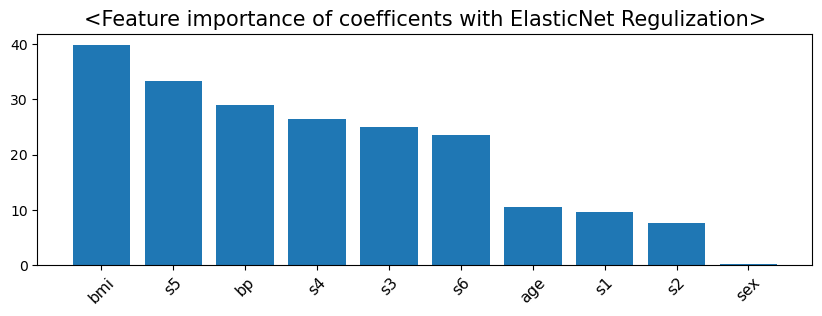

In [223]:

coef = np.abs(elasticnet_coef)    # 규제된 회귀계수의 절대값을 계산
coef = pd.Series(coef, index = diab.feature_names).sort_values(ascending = False)
coef
# 시각화
plt.figure(figsize = (10, 3))
plt.title('<Feature importance of coefficents with ElasticNet Regulization>',
         fontsize = 15)
plt.bar(coef.index, coef.values)
plt.xticks(coef.index, rotation = 45, fontsize = 11) ;

In [239]:
# alpha_list=[0.01, 1, 10, 100]인 경우, l1_ratio=0.5
alpha_list = [0.01, 1, 10, 100]
for each in alpha_list:
    model_elasticnet = ElasticNet(alpha=each)
    model_elasticnet.fit(x_train, y_train)
    y_pred = model_elasticnet.predict(x_test)
    r2 = r2_score(y_test, y_pred)
    col_name = f'ElasticNet(alpha={each:.2f})'
    comp_df[col_name] = np.append(model_elasticnet.coef_, r2)

In [240]:
comp_df

,LR,ridge(alpha = 0.01,ridge(alpha = 1.00,ridge(alpha = 10.00,ridge(alpha = 100.00,lasso(alpha = 0.01,lasso(alpha = 1.00,lasso(alpha = 10.00,lasso(alpha = 100.00,Elastic(alpha=0.01),ElasticNet(alpha=0.01),ElasticNet(alpha=1.00),ElasticNet(alpha=10.00),ElasticNet(alpha=100.00)
age,29.254013,34.167328,45.054210,16.230889,2.072848,28.246364,0.000000,0.000000,0.000000,0.000000,41.417999,0.367567,0.000000,0.000000
sex,-261.706469,-254.043316,-71.947397,-2.961367,-0.003808,-250.819184,-0.000000,0.000000,0.000000,0.000000,-45.935016,0.000000,0.000000,0.000000
bmi,546.299723,550.844882,280.716252,59.524160,6.899915,556.215874,443.703388,0.000000,0.000000,0.000000,225.053463,3.512046,0.000000,0.000000
bp,388.398341,379.126708,195.212662,43.421300,5.085100,380.659502,51.601094,0.000000,0.000000,0.000000,158.163233,2.328646,0.000000,0.000000
s1,-901.959668,-404.253263,-2.229303,13.875073,2.069660,-468.739540,0.000000,0.000000,0.000000,0.000000,9.021067,0.380194,0.000000,0.000000
s2,506.763241,123.029219,-17.540797,10.865267,1.743748,166.993417,0.000000,0.000000,0.000000,0.000000,-1.762029,0.168337,0.000000,0.000000
s3,121.154351,-99.041674,-148.688862,-37.495847,-4.508876,-60.219459,-0.000000,-0.000000,-0.000000,-0.000000,-124.240022,-1.955958,-0.000000,-0.000000
s4,288.035267,215.032624,120.467240,38.728538,4.902421,230.916253,0.000000,0.000000,0.000000,0.000000,106.910117,2.228128,0.000000,0.000000
s5,659.268951,463.842634,198.614401,49.224746,5.926496,492.634358,201.966478,0.000000,0.000000,0.000000,165.006085,2.887428,0.000000,0.000000
s6,41.376701,50.351490,106.934692,34.737987,4.328698,43.969346,0.000000,0.000000,0.000000,0.000000,97.213477,1.846225,0.000000,0.000000


### LassoCV() : k-폴드 교차 검증으로 최적의 Lasso 모델 하이퍼파라미터 alpha 찾기

In [226]:
#LassoCV()에 필요한 매개변수 설정
#0.01 ~ 9.91 까지 alpha_list  생성
cv = 5
alpha_list = np.arange(0.01, 10, 0.01)
max_iter = 1000

In [227]:
from sklearn.linear_model import LassoCV
model_lassocv = LassoCV(alphas = alpha_list, cv = 5, max_iter = 1000, n_jobs = -1,
       random_state = 42)

- 모델 학습

In [228]:
model_lassocv.fit(x_train,y_train)

LassoCV(alphas=array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67...
       9.25, 9.26, 9.27, 9.28, 9.29, 9.3 , 9.31, 9.32, 9.33, 9.34, 9.35,
       9.36, 9.37, 9.38, 9.39, 9.4 , 9.41, 9.42, 9.43, 9.44, 9.45, 9.46,
       9.47, 9.48, 9.49, 9.5 , 9.51, 9.52, 9.53, 9.54, 9.55, 9.56, 9.57,
       9.58, 9.59, 9.6 , 9.61, 9.62, 9.63, 9.64, 9.65, 9.66, 9.67, 9.68,
       9.69, 9.7 , 9.71, 9.72, 9.73, 9.74, 9.75, 9.76, 9.77, 9.78, 9.79,
       9.8 , 9.81, 9.82, 9.83, 9.84, 9.85, 9.86, 9.87, 9.88, 9.89, 9.9 ,
       9.91, 9.92, 9.93, 9.94, 9.95, 9.96, 9.97, 9.98, 9.99]),
        cv=5, n_jobs=-1, random_state=42)

In [229]:
model_lassocv.alpha_

0.01

In [230]:
y_pred = model_lassocv.predict(x_test)
r2_score(y_test, y_pred)

0.47871428812904404

## GridSearchCV

In [231]:
from sklearn.model_selection import GridSearchCV
model = ElasticNet()
param_grid = {
    'alpha' : [0.01, 1, 10, 100],
    'l1_ratio' : [0.1, 0.3, 0.6, 0.9]} # 총 48번 진행
grid = GridSearchCV(ElasticNet(), param_grid = param_grid, cv = 3)

In [232]:
grid.fit(x_train, y_train)

GridSearchCV(cv=3, estimator=ElasticNet(),
             param_grid={'alpha': [0.01, 1, 10, 100],
                         'l1_ratio': [0.1, 0.3, 0.6, 0.9]})

In [233]:
y_pred = grid.predict(x_test)
r2 = r2_score(y_test,y_pred)
print(r2)

0.47378958651114567


In [234]:
grid.best_params_

{'alpha': 0.01, 'l1_ratio': 0.9}

In [235]:
pd.DataFrame(grid.cv_results_).rank_test_score

0      4
1      3
2      2
3      1
4      8
5      7
6      6
7      5
8      9
9     10
10    10
11    10
12    10
13    10
14    10
15    10
Name: rank_test_score, dtype: int32

In [236]:
pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_l1_ratio,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.000358,0.000507,0.000663,0.000469,0.01,0.1,"{'alpha': 0.01, 'l1_ratio': 0.1}",0.263839,0.345717,0.220628,0.276728,0.051874,4
1,0.000999,0.000069,0.000308,0.000436,0.01,0.3,"{'alpha': 0.01, 'l1_ratio': 0.3}",0.295161,0.383803,0.247244,0.308736,0.056570,3
2,0.000992,0.000007,0.000332,0.000469,0.01,0.6,"{'alpha': 0.01, 'l1_ratio': 0.6}",0.357773,0.458940,0.297350,0.371355,0.066664,2
3,0.000332,0.000469,0.000998,0.000005,0.01,0.9,"{'alpha': 0.01, 'l1_ratio': 0.9}",0.448660,0.559716,0.354858,0.454411,0.083732,1
4,0.000330,0.000466,0.000666,0.000471,1,0.1,"{'alpha': 1, 'l1_ratio': 0.1}",-0.036596,0.006173,-0.054330,-0.028251,0.025395,8
5,0.000638,0.000452,0.000361,0.000511,1,0.3,"{'alpha': 1, 'l1_ratio': 0.3}",-0.035813,0.006724,-0.053471,-0.027520,0.025265,7
6,0.000000,0.000000,0.000996,0.000004,1,0.6,"{'alpha': 1, 'l1_ratio': 0.6}",-0.033089,0.008825,-0.050609,-0.024958,0.024936,6
7,0.000995,0.000013,0.000000,0.000000,1,0.9,"{'alpha': 1, 'l1_ratio': 0.9}",-0.014408,0.024254,-0.031096,-0.007083,0.023182,5
8,0.000999,0.000009,0.000000,0.000000,10,0.1,"{'alpha': 10, 'l1_ratio': 0.1}",-0.043113,-0.000548,-0.060565,-0.034742,0.025207,9
9,0.000998,0.000006,0.000000,0.000000,10,0.3,"{'alpha': 10, 'l1_ratio': 0.3}",-0.043425,-0.000801,-0.060893,-0.035039,0.025239,10


In [237]:
pd.DataFrame(grid.cv_results_)[['mean_test_score','rank_test_score']]

,mean_test_score,rank_test_score
0,0.276728,4
1,0.308736,3
2,0.371355,2
3,0.454411,1
4,-0.028251,8
5,-0.027520,7
6,-0.024958,6
7,-0.007083,5
8,-0.034742,9
9,-0.035039,10


In [238]:
pd.DataFrame(grid.cv_results_).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   mean_fit_time      16 non-null     float64
 1   std_fit_time       16 non-null     float64
 2   mean_score_time    16 non-null     float64
 3   std_score_time     16 non-null     float64
 4   param_alpha        16 non-null     object 
 5   param_l1_ratio     16 non-null     object 
 6   params             16 non-null     object 
 7   split0_test_score  16 non-null     float64
 8   split1_test_score  16 non-null     float64
 9   split2_test_score  16 non-null     float64
 10  mean_test_score    16 non-null     float64
 11  std_test_score     16 non-null     float64
 12  rank_test_score    16 non-null     int32  
dtypes: float64(9), int32(1), object(3)
memory usage: 1.7+ KB


## [응용] 보스턴 주택가격 데이터를 활용하여, 규제가 없을때, 리지, 라쏘, 엘라스틱넷 선형회귀를 수행하고 각각의 회귀계수 및 예측 성능을 비교하라
테스트 사이즈:0.3
random_state=42
